# Modeling and Simulation in Python

Chapter 2:

Copyright 2017 Allen Downey

License: [Creative Commons Attribution 4.0 International](https://creativecommons.org/licenses/by/4.0)


We'll start with the same code we saw last time: the magic command that tells Jupyter where to put the figures, and the import statement that gets the function defined in the `modsim` module.

In [1]:
# If you want the figures to appear in the notebook, use
# %matplotlib notebook

# If you want the figures to appear in separate windows, use
# %matplotlib qt

# To switch from one to another, you have to select Kernel->Restart

%matplotlib notebook

from modsim import *

## More than one state object

Here's the code from the previous chapter, with two changes:

1. I've added DocStrings that explain what each function does, and what parameters it takes.

2. I've added a parameter named `state` to the functions so they work with whatever state object we give them, instead of always using `bikeshare`.  That will be useful soon when we have more than one state object.

In [2]:
def run_steps(state, sum_steps=1, p1=0.5, p2=0.5):
    """Simulate the given number of time steps.
    
    state: bikeshare State object
    sum_steps: number of time steps
    p1: probability of an Olin->Wellesley customer arrival
    p2: probability of a Wellesley->Olin customer arrival
    """
    for i in range(sum_steps):
        step(state, p1, p2)
        plot_state(state)
        
def step(state, p1=0.5, p2=0.5):
    """Simulate one minute of time.
    
    state: bikeshare State object
    p1: probability of an Olin->Wellesley customer arrival
    p2: probability of a Wellesley->Olin customer arrival
    """
    if flip(p1):
        bike_to_wellesley(state)
    
    if flip(p2):
        bike_to_olin(state)
        
def bike_to_wellesley(state):
    """Move one bike from Olin to Wellesley.
    
    state: bikeshare State object
    """
    move_bike(state, 1)
    
def bike_to_olin(state):
    """Move one bike from Olin to Wellesley.
    
    state: bikeshare State object
    """
    move_bike(state, -1)
    
def move_bike(state, n):
    """Move a bike.
    
    state: bikeshare State object
    n: +1 to move from Olin to Wellesley or
       -1 to move from Wellesley to Olin
    """
    state.olin -= n
    state.wellesley += n
    
def plot_state(state):
    """Plot the current state of the bikeshare system.
    
    state: bikeshare State object
    """
    plot(state.olin, 'rs-', label='Olin')
    plot(state.wellesley, 'bo-', label='Wellesley')
    
def annotate():
    """Add a legend and label the axes.
    """
    legend(loc='best')
    label_axes(title='Olin-Wellesley Bikeshare',
               xlabel='Time step (min)', 
               ylabel='Number of bikes')

Now we can create more than one state object:

In [3]:
bikeshare1 = State(olin=10, wellesley=2)
bikeshare1

wellesley -> 2
olin -> 10

In [4]:
bikeshare2 = State(olin=2, wellesley=10)
bikeshare2

olin -> 2
wellesley -> 10

And whenever we call a function, we indicate which state object to work with:

In [5]:
bike_to_olin(bikeshare1)

In [6]:
bike_to_wellesley(bikeshare2)

And you can confirm that the different states are getting updated independently:

In [7]:
bikeshare1

wellesley -> 1
olin -> 11

In [8]:
bikeshare2

olin -> 1
wellesley -> 11

## Negative bikes

In the code we have so far, the number of bikes at one of the locations can go negative, and the number of bikes at the other location can exceed the actual number of bikes in the system.

If you run this simulation a few times, it happens quite often.

<IPython.core.display.Javascript object>


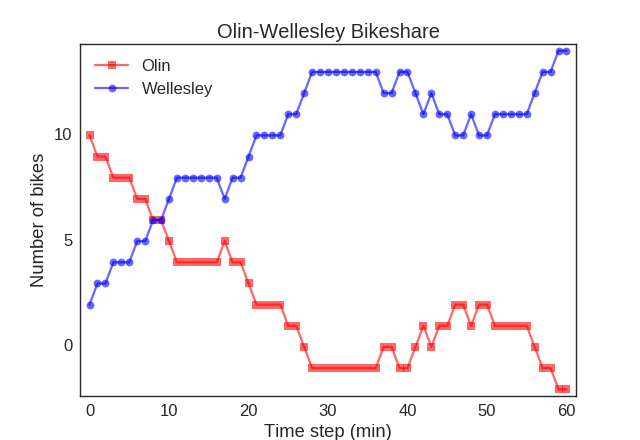

In [9]:
bikeshare = State(olin=10, wellesley=2)
newfig()
plot_state(bikeshare)
annotate()
run_steps(bikeshare, 60, 0.4, 0.2)

But this is relatively easy to fix, using the `return` statement to exit the function early if the update would cause negative bikes.

If the second `if` statement seems confusing, remember that `n` can be negative.

In [10]:
def move_bike(state, n):
    # make sure the number of bikes won't go negative
    olin = state.olin - n
    if olin < 0:
        return
    
    wellesley = state.wellesley + n
    if wellesley < 0:
        return
    
    # update the state
    state.olin = olin
    state.wellesley = wellesley

Now if you run the simulation again, it should behave.

<IPython.core.display.Javascript object>


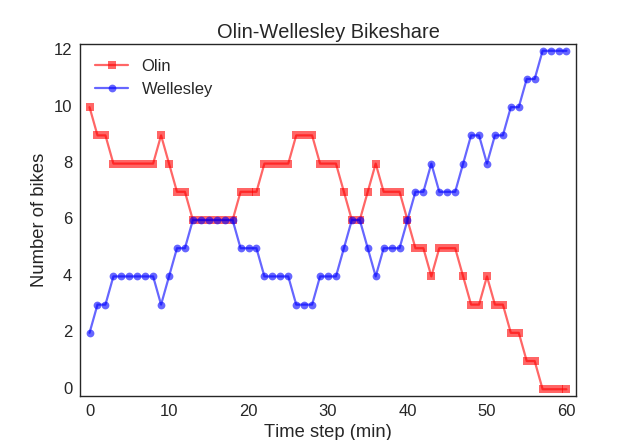

In [11]:
bikeshare = State(olin=10, wellesley=2)
newfig()
plot_state(bikeshare)
annotate()
run_steps(bikeshare, 60, 0.4, 0.2)

The variables `olin` and `wellesley` are created inside `move_bike`, so they are local.  When the function ends, they go away.

If you try to access a local variable from outside its function, you get an error:

In [12]:
# NameError: name 'olin' is not defined

olin

NameError: name 'olin' is not defined

## Comparison operators

The `if` statements in the previous section used the comparison operator `<`.  The other comparison operators are listed in the book.

It is easy to confuse the comparison operator `==` with the assignment operator `=`.

Remember that `=` creates a variable or gives an existing variable a new value.

In [13]:
x = 5

Whereas `==` compared two values and returns `True` if they are equal.

In [14]:
x == 5

True

You can use `==` in an `if` statement.

In [15]:
if x == 5:
    print('yes, x is 5')

yes, x is 5


But if you use `=` in an `if` statement, you get an error.

In [16]:
# SyntaxError: invalid syntax

if x = 5:
    print('yes, x is 5')

SyntaxError: invalid syntax (<ipython-input-16-08914bc96ca4>, line 3)

## Metrics

Now that we have a working simulation, we'll use it to evaluate alternative designs and see how good they are.  The metric we'll use is the number of customers who arrive and find no bikes available.

First we'll make a new state object that creates and initializes the state variables that will keep track of the metrics.

In [17]:
bikeshare = State(olin=10, wellesley=2, 
                  olin_empty=0, wellesley_empty=0)

Next we need a version of `move_bike` that updates the metrics.

In [18]:
def move_bike(state, n):
    olin = state.olin - n
    if olin < 0:
        state.olin_empty += 1
        return
    
    wellesley = state.wellesley + n
    if wellesley < 0:
        state.wellesley_empty += 1
        return
    
    state.olin = olin
    state.wellesley = wellesley

Now when we run a simulation, it keeps track of unhappy customers.

<IPython.core.display.Javascript object>


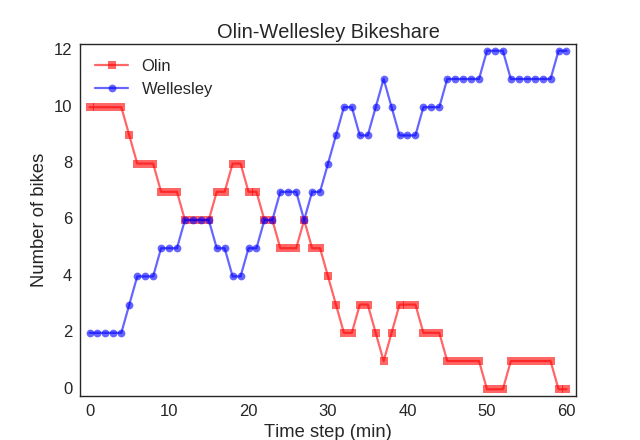

In [19]:
newfig()
plot_state(bikeshare)
annotate()
run_steps(bikeshare, 60, 0.4, 0.2)

After the simulation, we can print the number of unhappy customers at each location.

In [20]:
bikeshare.olin_empty

1

In [21]:
bikeshare.wellesley_empty

0

**Exercise:** Let's add a "clock" to keep track of how many time steps have elapsed:

1. Add a new state variable named `clock` to `bikeshare`, initialized to 0, and 

2. Modify `step` so it increments (adds one to) `clock` each time it is invoked.

Test your code by adding a print statement that prints the value of `clock` at the beginning of each time step.

In [22]:
# Solution

bikeshare = State(olin=10, wellesley=2, 
                  olin_empty=0, wellesley_empty=0,
                  clock=0)

In [23]:
# Solution

def move_bike(state, n):
    state.clock += 1
    # print(state.clock)
    
    olin = state.olin - n
    if olin < 0:
        state.olin_empty += 1
        return
    
    wellesley = state.wellesley + n
    if wellesley < 0:
        state.wellesley_empty += 1
        return
    
    state.olin = olin
    state.wellesley = wellesley

<IPython.core.display.Javascript object>


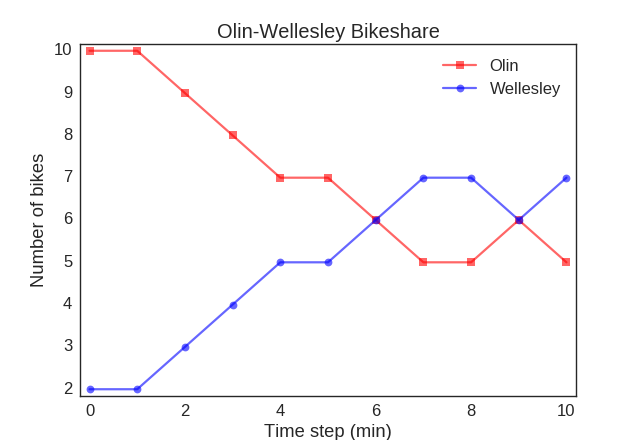

In [24]:
# Solution

newfig()
plot_state(bikeshare)
annotate()
run_steps(bikeshare, 10, 0.4, 0.2)

**Exercise:** Now suppose we'd like to know how long it takes to run out of bikes at either location.  Modify `move_bike` so the first time a student arrives and doesn't find a bike, it records the value of `clock` in a state variable.

Hint: create a state variable named `t_first_empty` and initialize it to `None`, which is a special value (like `True` and `False`) that can be used to indicate a "special case".

Test your code by running a simulation for 60 minutes and checking the metrics.

In [25]:
# Solution

bikeshare = State(olin=10, wellesley=2, 
                  olin_empty=0, wellesley_empty=0,
                  clock=0, t_first_empty=None)

In [26]:
# Solution

def move_bike(state, n):
    state.clock += 1
    # print(state.clock)
    
    olin = state.olin - n
    if olin < 0:
        state.olin_empty += 1
        if state.t_first_empty == None:
            state.t_first_empty = state.clock
        return
    
    wellesley = state.wellesley + n
    if wellesley < 0:
        state.wellesley_empty += 1
        return
    
    state.olin = olin
    state.wellesley = wellesley

<IPython.core.display.Javascript object>


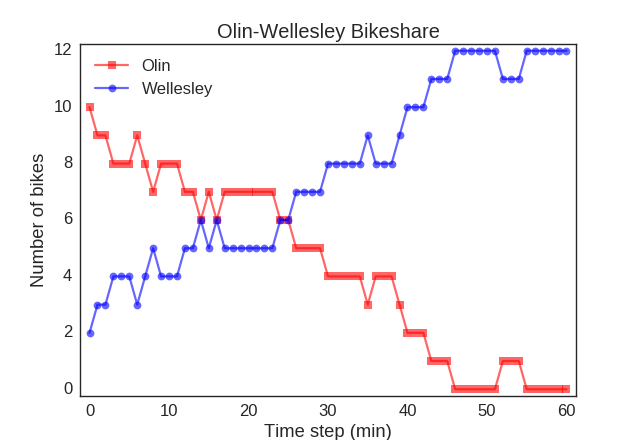

In [27]:
# Solution

newfig()
plot_state(bikeshare)
annotate()
run_steps(bikeshare, 60, 0.4, 0.2)

In [28]:
# Solution

bikeshare.t_first_empty

21

Before we go on, let's put `move_bike` back the way we found it.

In [29]:
def move_bike(state, n):
    olin = state.olin - n
    if olin < 0:
        state.olin_empty += 1
        return
    
    wellesley = state.wellesley + n
    if wellesley < 0:
        state.wellesley_empty += 1
        return
    
    state.olin = olin
    state.wellesley = wellesley

## Returning values

Here's a simple function that returns a value:

In [30]:
def add_five(x):
    return x + 5

And here's how we call it.

In [31]:
y = add_five(3)
y

8

If you run a function on the last line of a cell, Jupyter displays the result:

In [32]:
add_five(5)

10

But that can be a bad habit, because usually if you call a function and don't assign the result in a variable, the result gets discarded.

In the following example, Jupyter shows the second result, but the first result just disappears.

In [33]:
add_five(3)
add_five(5)

10

When you call a function that returns a variable, it is generally a good idea to assign the result to a variable.

In [34]:
y1 = add_five(3)
y2 = add_five(5)

print(y1, y2)

8 10


## Running simulations

Before we go on, I want to update `run_steps` so it doesn't always plot the results.  The new version takes an additional parameter, `plot_flag`, to indicate whether we want to plot.

`flag` is a conventional name for a boolean variable that indicates whether or not a condition is true.

In [35]:
def run_steps(state, sum_steps=1, p1=0.5, p2=0.5, plot_flag=True):
    """Simulate the given number of time steps.
    
    state: bikeshare State object
    sum_steps: number of time steps
    p1: probability of an Olin->Wellesley customer arrival
    p2: probability of a Wellesley->Olin customer arrival
    plot_flag: boolean, whether to plot
    """
    for i in range(sum_steps):
        step(state, p1, p2)
        if plot_flag:
            plot_state(state)

Now when we run a simulation, we don't get a figure.

In [36]:
bikeshare = State(olin=10, wellesley=2, 
                  olin_empty=0, wellesley_empty=0)
run_steps(bikeshare, 60, 0.4, 0.2, plot_flag=False)

But we can read the metrics.

In [37]:
bikeshare.olin_empty

8

Let's wrap all that in a function.

In [38]:
def run_simulation():
    bikeshare = State(olin=10, wellesley=2, 
                  olin_empty=0, wellesley_empty=0)
    run_steps(bikeshare, 60, 0.4, 0.2, plot_flag=False)
    return bikeshare

And test it.

In [39]:
state = run_simulation()

In [40]:
print(state.olin_empty, state.wellesley_empty)

0 1


If we generalize `run_simulation` to take `p1` and `p2`, we can use it to run simulations with a range of values for the parameters.

In [41]:
def run_simulation(p1=0.4, p2=0.2):
    bikeshare = State(olin=10, wellesley=2, 
                  olin_empty=0, wellesley_empty=0)
    run_steps(bikeshare, 60, p1, p2, plot_flag=False)
    return bikeshare

When `p1` is small, we probably don't run out of bikes at Olin.

In [42]:
state = run_simulation(p1=0.2)
state.olin_empty

0

When `p1` is large, we probably do.

In [43]:
state = run_simulation(p1=0.6)
state.olin_empty

15

**Exercise:**  Write a version of `run_simulation` that takes all five model parameters as function parameters.

In [44]:
# Solution

def run_simulation(p1=0.4, p2=0.2, olin=10, wellesley=2, num_steps=60):
    bikeshare = State(olin=olin, wellesley=wellesley, 
                  olin_empty=0, wellesley_empty=0)
    run_steps(bikeshare, num_steps, p1, p2, plot_flag=False)
    return bikeshare

In [45]:
# Solution

run_simulation(p1=0.2, p2=0.4, olin=3, wellesley=9, num_steps=30)

wellesley_empty -> 0
olin -> 11
olin_empty -> 0
wellesley -> 1

**Exercise:**  Write a version of `run_simulation` that takes all five model parameters in a state object.

In [46]:
# Solution

def run_simulation(params):
    bikeshare = State(olin=params.olin, wellesley=params.wellesley, 
                  olin_empty=0, wellesley_empty=0)
    run_steps(bikeshare, params.num_steps, params.p1, params.p2, plot_flag=False)
    return bikeshare

In [47]:
# Solution

params = State(p1=0.2, p2=0.4, olin=3, wellesley=9, num_steps=30)
run_simulation(params)

wellesley_empty -> 0
olin -> 5
olin_empty -> 0
wellesley -> 7

Before we go on, let's put `run_simulation` back the way we found it.

In [48]:
def run_simulation(p1=0.4, p2=0.2):
    bikeshare = State(olin=10, wellesley=2, 
                  olin_empty=0, wellesley_empty=0)
    run_steps(bikeshare, 60, p1, p2, plot_flag=False)
    return bikeshare

## More for loops

Here's a `for` loop that prints the loop variable. 

In [49]:
for i in range(4):
    print(i)

0
1
2
3


**Exercise:** [Read about the range function](http://pythoncentral.io/pythons-range-function-explained/) and use it to print all the multiples of 3 less than 20.

In [50]:
# Solution

for i in range(3, 20, 3):
    print(i)

3
6
9
12
15
18


`linspace` creates an array of equally spaced numbers.

In [51]:
linspace(start=0, stop=1, num=11)

array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ])

We can use an array in a `for` loop, like this:

In [52]:
p1_array = linspace(0, 1, 11)

for p1 in p1_array:
    print(p1)

0.0
0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9
1.0


This will come in handy in the next section.

**Exercise:** The function `linspace` is part of NumPy.  [You can read the documentation here](https://docs.scipy.org/doc/numpy/reference/generated/numpy.linspace.html).

Use `linspace` to make an array of 10 equally spaced numbers from 1 to 10 (including both).

In [53]:
# Solution

linspace(1, 10, 10)

array([  1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.])

**Exercise:** NumPy provides a related function called `arange`.  [You can read the documentation here](https://docs.scipy.org/doc/numpy/reference/generated/numpy.arange.html). 

Use `arange` to make an array of 10 equally spaced numbers from 1 to 10 (including both).

In [54]:
# Solution

arange(1, 11)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

## Sweeping parameters

The following example runs simulations with a range of values for `p1`; after each simulation, it prints the number of unhappy customers at the Olin station:

In [55]:
p1_array = linspace(0, 1, 11)

for p1 in p1_array:
    state = run_simulation(p1=p1)
    print(p1, state.olin_empty)

0.0 0
0.1 0
0.2 0
0.3 4
0.4 7
0.5 5
0.6 19
0.7 19
0.8 29
0.9 31
1.0 35


Now we can do the same thing, but plotting the results instead of printing them.



<IPython.core.display.Javascript object>


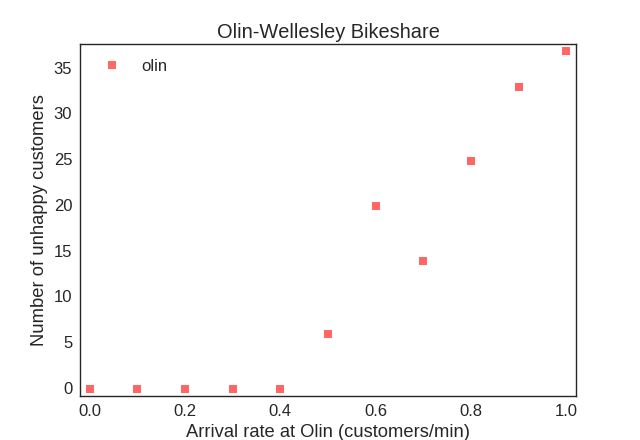

In [56]:
newfig()
for p1 in p1_array:
    state = run_simulation(p1=p1)
    plot(p1, state.olin_empty, 'rs', label='olin')

As always, we should annotate the figure.

In [57]:
def annotate():
    legend(loc='upper left')
    label_axes(title='Olin-Wellesley Bikeshare',
               xlabel='Arrival rate at Olin (customers/min)', 
               ylabel='Number of unhappy customers')

In [58]:
annotate()

**Exercise:** Wrap this code in a function named `parameter_sweep` that takes an array called `p1_values` as a parameter.  It should create a new figure, run a simulation for each value of `p1` in `p1_value`, and plot the results.

Once you have the function working, modify it so it also plots the number of unhappy customers at Wellesley.  Looking at the plot, can you estimate a range of values for `p1` that minimizes the total number of unhappy customers?

In [59]:
# Solution

def parameter_sweep(p1_array):
    for p1 in p1_array:
        state = run_simulation(p1)
        plot(p1, state.olin_empty, 'rs', label='Olin')
        plot(p1, state.wellesley_empty, 'bo', label='Wellesley')

<IPython.core.display.Javascript object>


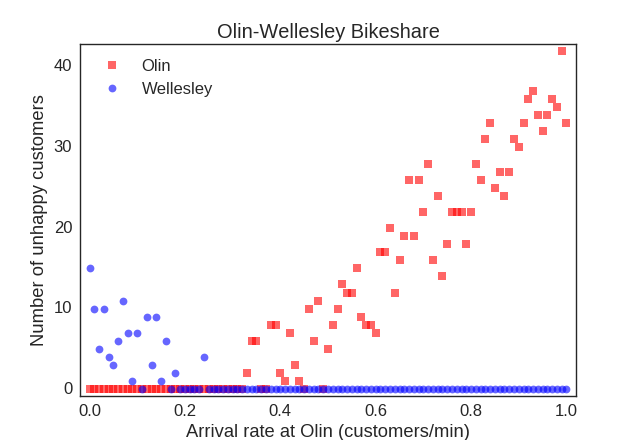

In [60]:
# Solution

newfig()
p1_array = linspace(0, 1, 101)
parameter_sweep(p1_array)
annotate()

**Exercise:** Hold `p1=0.2` and sweep a range of values for `p2`.

In [61]:
# Solution

def parameter_sweep2(p2_array):
    for p2 in p2_array:
        state = run_simulation(p1=0.2, p2=p2)
        plot(p2, state.olin_empty, 'rs', label='Olin')
        plot(p2, state.wellesley_empty, 'bo', label='Wellesley')

<IPython.core.display.Javascript object>


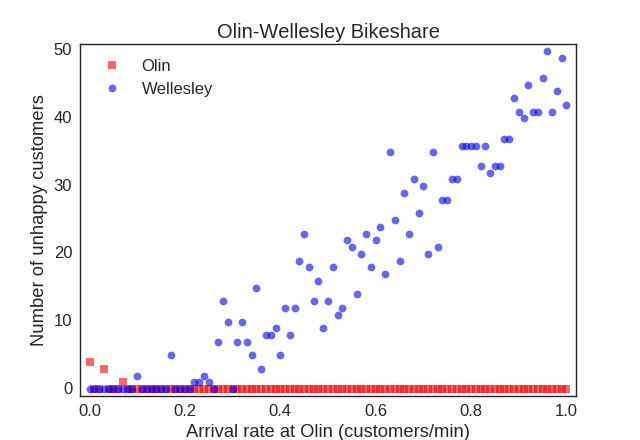

In [62]:
# Solution

newfig()
p2_array = linspace(0, 1, 101)
parameter_sweep2(p2_array)
annotate()

**Exercise:** Hold `p1=0.4` and `p2=0.2`, and sweep a range of values for `num_steps`.

Hint: Use the version of `run_simulation` that takes as a parameter a state object with the model parameters.

Hint: Because `num_steps` is supposed to be an integer use `range` rather than `linspace`.

In [63]:
# Solution

def run_simulation(params):
    bikeshare = State(olin=params.olin, wellesley=params.wellesley, 
                  olin_empty=0, wellesley_empty=0)
    run_steps(bikeshare, params.num_steps, params.p1, params.p2, plot_flag=False)
    return bikeshare

In [64]:
# Solution

def parameter_sweep3(num_steps_array):
    for num_steps in num_steps_array:
        params = State(p1=0.2, p2=0.4, olin=3, wellesley=9, num_steps=num_steps)
        state = run_simulation(params)
        plot(num_steps, state.olin_empty, 'rs', label='Olin')
        plot(num_steps, state.wellesley_empty, 'bo', label='Wellesley')

<IPython.core.display.Javascript object>


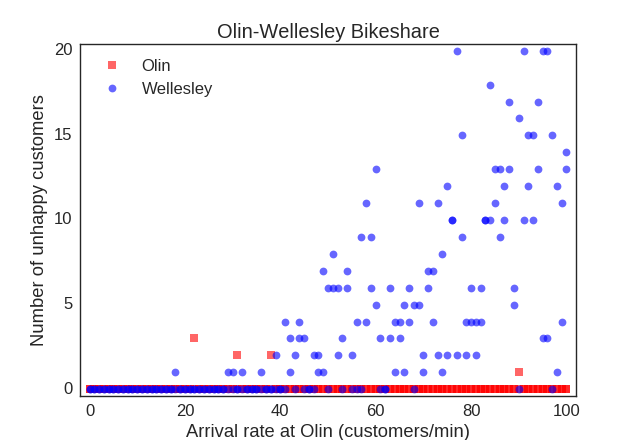

In [65]:
# Solution

newfig()
num_steps_array = arange(101)
parameter_sweep3(num_steps_array)
annotate()

In [66]:
parameter_sweep3(num_steps_array)
